### Stworzenie sieci neuronowej
#### Wykorzystałem sieć neuronową trzywarstwą ponieważ przynosiła najlepsze wyniki po walidacji modelu (modele 2 i 4 warstwowe przynosiły gorsze wyniki). Dwie pierwsze warstwy posiadają funkcje aktywacji ReLu, która na wszystkich wyjściach zwraca wynik funkcji max(0, x), czyli masimum dla wartości dodatnich i 0 dla wartości ujemnych. Ostatnia warstwa nie posiada funkcji aktywacji (miałem wykorzystać funkcję softmax, ale w związku z wykorzystaniem podczas trenowania, funkcji straty Cross Entropy Loss, która wykonuje softmax wewnętrzne przed wykonaniem obliczeń, nie ma takiej potrzeny).

In [1]:
import torch 
from torch import nn
import numpy as np
class LangClassifier(nn.Module): # utworzenie sieci neuronowej
    def __init__(self):
        super().__init__()        
        self.mlp = nn.Sequential(
            nn.Linear(384, 200),
            nn.ReLU(),          
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
        )
    
    def forward(self, x):
        return self.mlp(x)

### Pobranie i podzielenie wcześniej przygotowanych danych

In [6]:
import pandas as pd 
# Wczytuje dane z embendingami
df = pd.read_feather("dataset/languages_with_embeddings.bin")

In [7]:
# dokonuję losowego przetasowania
df = df.sample(frac=1.0)
# Dzielę dane na treningowe, validacyjne i testowe (50k, 10k, 10k) 
train_df = df[:50000] # dane do treningowe
val_df = df[50000:60000] # dane validacyjne
test_df = df[60000:] # dane testowe
train_df.head(n=10)

,Unnamed: 0,labels,text,enc_labels,embeddings
43739,43739,pl,"irak lobbował na rzecz rady bezpieczeństwa, by...",11,"[-0.09441936, 0.1498231, -0.10541683, 0.008297..."
35818,35818,sw,"Kwa hakika , i , i mwaka jana .",14,"[-0.081501804, 0.14022341, -0.04914736, 0.0101..."
49034,49034,el,Οι αξιολογήσεις της nielsen δείχνουν ότι οι νέ...,3,"[-0.048229992, 0.06984926, 0.018829627, -0.019..."
63771,63771,it,"La Corea del Nord fa progressi ""significativi""...",8,"[0.0073714918, 0.07323343, -0.07855317, 0.0130..."
45200,45200,ur,جی ہاں میں عام طور پر ایک سال سے زیادہ عرصہ می...,17,"[0.09197652, 0.030413011, -0.046798475, 0.0229..."
24481,24481,sw,Well see i didn ' t either mpaka ni,14,"[0.005001271, 0.02950328, -0.0291192, -0.03092..."
6844,6844,ar,انت اردت عمي ( ديفيد ارنولد هانسون ) .,0,"[0.019821683, 0.036433343, -0.013465836, -0.02..."
21884,21884,hi,शोध और विकास,7,"[-0.0115932785, 0.16010122, -0.07427981, -0.03..."
43462,43462,en,The app for this is probably the main reason f...,4,"[-0.035440657, -0.043055307, 0.026748372, -0.0..."
7438,7438,tr,"Her ikisi için de son çok güzel gün bayan , mu...",16,"[-0.09303257, 0.095158644, -0.023077892, -0.01..."


### Trenowanie i walidacja modelu oraz wykorzystanie metryki accuracy do klasyfikacji wieloklasowej

In [139]:
from torchmetrics import Accuracy
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter() # inicializacja narzędzia do rejestrowania danych i metryk podczas treningu modelu w PyTorch z biblioteki TensorBoard, która pozwala na wizualizację i monitorowanie danych
model = LangClassifier() # zdefiniowanie instancji naszego modelu sieci neuronowej
ce_loss = nn.CrossEntropyLoss() # Zastosowanie funkcji straty Cross-Entropy Loss, która związana jest z wieloklasową klasyfikacją

batch_size = 100 # ustawienie paczki danych, które są obrabiane na raz podczas jednej pętli w danej epoce w czasie uczenia się (wybrałem sto celem umożliwienia sprawnego trenowania)
adam_optimizer = torch.optim.Adam(model.parameters()) # Zastosowanie optymalizatora Adam
nr_of_epochs = 10
losses = []
best_accuracy = 0.0
best_accuracy_epoch = 0
for epoch in tqdm(range(nr_of_epochs)):
    
    train_df = train_df.sample(frac=1.0)  # losowe przetasowanie całego treningowego_dataframe (frac=1.0 - oznacza żeby funkcja sample zwróciła cały przetasowany df) 
    current_index = 0 # ustawienie indeksu na 0 dla pętli while liczenia kolejnej epoki
    while current_index < len(train_df): # jeżeli obecny index jest mniejszy niż ostatni ro wykonuj się       
        # Najpierw tworzą się próbki danych x - embeddnings i y - encoded labels (najperw wiciągam listy z kolumn naszego df i tworzę z nich tablicę)
        batch_x = np.array(
            train_df.embeddings[current_index:(current_index + batch_size)].tolist()
        )
        batch_y = np.array(
            train_df.enc_labels[current_index: (current_index + batch_size)].tolist()
        )

        # Następnie tworzę z tablic tensory potrzebne do wykonania trenowania
        tensor_batch_x = torch.Tensor(batch_x)
        tensor_batch_y = torch.Tensor(batch_y)

        # Tu następuje predykcja i obliczenie funkcji straty
        pred = model.forward(tensor_batch_x) 
        loss = ce_loss(pred, tensor_batch_y.long())
 
        # Backpropagation
        loss.backward() # Liczenie gradientu wag modelu - czyli wektorów wskazujących na kierunek zmian wag
        adam_optimizer.step() # adam oblicza nowe parametry sieci na podstawie obliczonych gradientów
        adam_optimizer.zero_grad()
        
        losses.append(float(loss.detach().numpy())) # wyodrębniam wartość funkcji straty z tensora PyTorch loss, a następnie konwertuje ją na liczbę zmiennoprzecinkową i dodaje do listy losses.
        current_index += batch_size
    
    model.eval() # ustawienie modelu w tryb ewaluacji celem umożliwienia prawidłowej ewaluacji (niektóre warstwy modelu zachowują się inaczej w tym trybie)
    metric = Accuracy(task='MULTICLASS', num_classes=20) # utworzenie obiektu metryki Accuracy do klasyfikacji wieloklasowej (liczba klas 20)
    for _, eval_row in tqdm(val_df.iterrows(), desc='evaluating'): # iteracja pętli po każdym wierszu val_df (danych walidacyjnych)
        pred = model.forward(
            torch.Tensor(np.array(eval_row.embeddings)) # obliczenie predykcji dla linijki danych walidacyjnych
        )
        metric.update(torch.argmax(pred).unsqueeze(0), torch.Tensor([eval_row.enc_labels])) # zupdatowanie predykcji w metryce porównując do właściej wartości
    metric_value = metric.compute() # obliczenie wartości metryki Accuracy na podstawie wszystkich uaktualnień przeprowadzonych podczas iteracji po danych walidacyjnych
    writer.add_scalar('Accuracy/eval', metric_value, epoch) # metryki do rejestratora potrzebnego do wyświetlenia w TensorBoard
    
    if metric_value > best_accuracy:
        best_accuracy = metric_value
        best_accuracy_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth') # zapisz model jeżeli jest lepszy od poprzednio zapisanego

model.load_state_dict(torch.load('best_model.pth'))  # załaduj wagi z zapisanego najlepszego  modelu

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

evaluating: 0it [00:00, ?it/s]

<All keys matched successfully>

In [141]:
print(f"Najlepsza dokładność modelu została osiągnięta w {best_accuracy_epoch} epoce i wynosiła {best_accuracy*100}%")

Najlepsza dokładność modelu została osiągnięta w 7 epoce i wynosiła 98.0%


### Wykers dokładności predykcji
#### Aby wyświetlić wykres dokładności predykcji w kolejnych epokach na podsawie danych zapisanych w utworzonym folderze runs należy wykorzystać TensorBoard
#### Komenda do terminala: "tensorboard --logdir=runs"


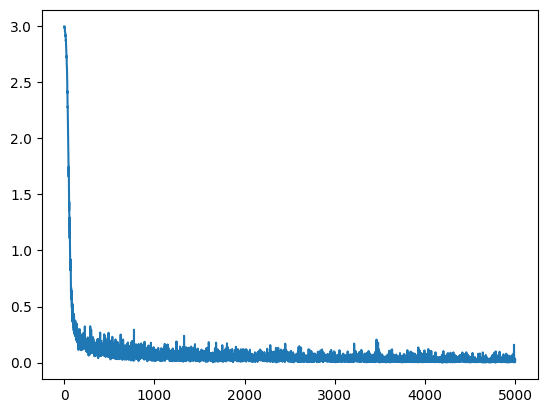

In [142]:
# dodatkowo wyświetlenie wykresu z listą zapisanych strat
import matplotlib.pyplot as plt
plt.plot(losses)

### Testowanie modelu

In [143]:
# wyjświetlenie pierwszych 10 lini dla test_df
test_df.head(n=10)

,Unnamed: 0,labels,text,enc_labels,embeddings
25542,25542,pl,Chapman nie został natychmiast aresztowany i o...,11,"[-0.037656464, 0.10963181, -0.0625423, 0.03107..."
11899,11899,es,"Estoy contenta con la compra, cuando meto las ...",5,"[0.09058217, 0.08858652, 0.0128650265, -0.1038..."
47626,47626,vi,Tôi không giúp họ tôi làm việc với họ không ph...,18,"[-0.08829949, 0.018498808, -0.05205665, -0.081..."
57541,57541,zh,这是网购以来，收货耗时最久的一次，不是之一。比双11还久。10月6日发出订单，直到20日才到...,19,"[0.07296511, 0.040647928, 0.1040279, -0.005607..."
17575,17575,zh,就像书里说的，看完之后，在互联网时代收获一份平静,19,"[0.016383432, 0.09206814, 0.08663628, 0.006355..."
11160,11160,tr,Bunlar yüksek standartlarını korumuş olan bir ...,16,"[-0.028618196, 0.0981894, -0.009314199, -0.025..."
43295,43295,es,El calzador va bien para no agacharse pero hay...,5,"[0.024856113, -0.003522059, 4.7007647e-06, -0...."
53592,53592,en,I love this product!!!! What I like the most i...,4,"[-0.06358813, -0.08612435, 0.054177534, -0.027..."
15372,15372,ru,К числу результатов этих проблем относятся уве...,13,"[0.029102057, 0.019167429, 0.019533556, -0.017..."
4003,4003,ru,"Смотрите , я записал убийство , которое она на...",13,"[0.010712243, 0.057449117, -0.062147424, -0.03..."


In [144]:
# Utworzenie słownika z istniejących języków i posortowanie go od 0 do 19
lang_dict = dict(sorted(dict(zip(df['enc_labels'], df['labels'])).items()))
print(lang_dict)

{0: 'ar', 1: 'bg', 2: 'de', 3: 'el', 4: 'en', 5: 'es', 6: 'fr', 7: 'hi', 8: 'it', 9: 'ja', 10: 'nl', 11: 'pl', 12: 'pt', 13: 'ru', 14: 'sw', 15: 'th', 16: 'tr', 17: 'ur', 18: 'vi', 19: 'zh'}


In [145]:
import torch.nn.functional as F

# Przygotowanie danych testowych
test_embeddings = torch.Tensor(np.array(test_df['embeddings'].tolist()))

# Uzyskanie predykcji dla danych testowych
test_pred = model.forward(test_embeddings)

# Przekształcenie wyników predykcji na prawdopodobieństwa przy użyciu funkcji softmax
test_prob = F.softmax(test_pred, dim=1)

# Znalezienie indeksu klasy z najwyższym prawdopodobieństwem dla każdego przykładu
pred_indexes = torch.argmax(test_prob, dim=1)

# Przetłumaczenie indeksów klas na odpowiadające języki
pred_lang = [lang_dict[i.item()] for i in pred_indexes]

In [146]:
tested_df = test_df.copy()

# Dodanie przewidywanych języków do ramki danych testowych
tested_df['predicted_language'] = pred_lang

# Sortowanie danych w df wg języka
tested_df = tested_df.sort_values(by='labels')

# Wyświetlenie przewidywanych języków dla danych testowych (30 pierwszych pozycji)
tested_df[['labels', 'predicted_language', 'text']].head(n=20)

,labels,predicted_language,text
25972,ar,ar,يجلس sourer ليعتقد اننا خدعنا فيه . الكشاف لمح...
29347,ar,ar,"واذا كان الامر كذلك , لماذا لا تتبع نفس الممار..."
53381,ar,ar,الاسرة والكراسي والمقاعد هي حيث يقوم التاريخ ب...
26453,ar,ar,لا ارى انني لا اعتقد ان هاتفي يفعل ذلك حقا ولك...
1775,ar,ar,النشاط ال الزلزالي القديم اجبر الصخرة الطبقية ...
13070,ar,ar,وتشدد المبادئ التوجيهية لجمع البيانات على مدى ...
24261,ar,ar,المدينة والريف
5957,ar,ar,"( 8 ) مرشح الامين العمل ( الكسيس هيرمان ) , ال..."
15226,ar,ar,او تحيا المانيا المقدسة !
62472,ar,ar,الاحجار السوداء شكلت حلقة حول منصة من الصخور ا...


In [147]:
# Wyświetlenie ilości rekordów dla danego języka w przetestowanym df
tested_df.labels.value_counts()

labels
ur    543
fr    540
it    539
ja    528
hi    516
es    515
vi    507
de    502
bg    502
zh    499
sw    492
ar    492
nl    489
ru    487
th    487
pl    486
el    479
en    468
tr    467
pt    462
Name: count, dtype: int64

In [148]:
from sklearn.metrics import f1_score

# Obliczenie dokładności dla każdego języka za pomocą F1-score
f1 = f1_score(tested_df['labels'], tested_df['predicted_language'], average=None)

In [149]:
# Stworzenie słownika z wynikami F1-score dla każdej z klas (języków)
lang_pred_score = {}
for i, score in enumerate(f1):
    lang_pred_score[lang_dict[i]] = score
print(lang_pred_score)

{'ar': 0.9979674796747967, 'bg': 0.9509803921568627, 'de': 0.989010989010989, 'el': 0.9989550679205852, 'en': 0.9904153354632588, 'es': 0.9854227405247813, 'fr': 0.9907578558225508, 'hi': 0.9942084942084942, 'it': 0.9711090400745573, 'ja': 0.9990521327014218, 'nl': 0.9634888438133874, 'pl': 0.9671457905544147, 'pt': 0.9685807150595883, 'ru': 0.9487983281086729, 'sw': 0.9724770642201835, 'th': 0.9958932238193019, 'tr': 0.9689174705251876, 'ur': 0.992619926199262, 'vi': 0.9940828402366864, 'zh': 1.0}


In [150]:
print('Dokładność dla danego języka w procentach:')
for lang, score in sorted(lang_pred_score.items(), key=lambda item: item[1], reverse=True):
    print(f"{lang} = {round(score*100, 2)}%")

Dokładność dla danego języka w procentach:
zh = 100.0%
ja = 99.91%
el = 99.9%
ar = 99.8%
th = 99.59%
hi = 99.42%
vi = 99.41%
ur = 99.26%
fr = 99.08%
en = 99.04%
de = 98.9%
es = 98.54%
sw = 97.25%
it = 97.11%
tr = 96.89%
pt = 96.86%
pl = 96.71%
nl = 96.35%
bg = 95.1%
ru = 94.88%


In [154]:
# wyświetlenie wszystkiego za pomocą confusion matrix
from sklearn.metrics import confusion_matrix

# Obliczenie confusion matrix
cm = confusion_matrix(tested_df['labels'], tested_df['predicted_language'], labels=sorted(lang_dict.values()))
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[491   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0]
 [  0 485   0   0   0   0   0   0   0   0   0   0   0  16   0   0   0   1
    0   0]
 [  0   0 495   0   0   0   1   0   1   0   5   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 478   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 465   0   0   0   0   0   2   0   0   0   0   0   0   1
    0   0]
 [  0   0   0   0   0 507   2   0   2   0   0   0   4   0   0   0   0   0
    0   0]
 [  0   0   1   0   0   0 536   0   1   0   1   0   0   0   0   0   0   0
    1   0]
 [  0   0   0   0   0   0   0 515   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   0   2   0   0 521   0   0   3   8   0   0   0   4   0
    1   0]
 [  0   0   0   0   1   0   0   0   0 527   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   1   0   0   0   1   0   1   0 475   5   0   0   1   0   5   0
    0   0]
 [  0   0   0   0   0   0   0   0   2   0   5 4

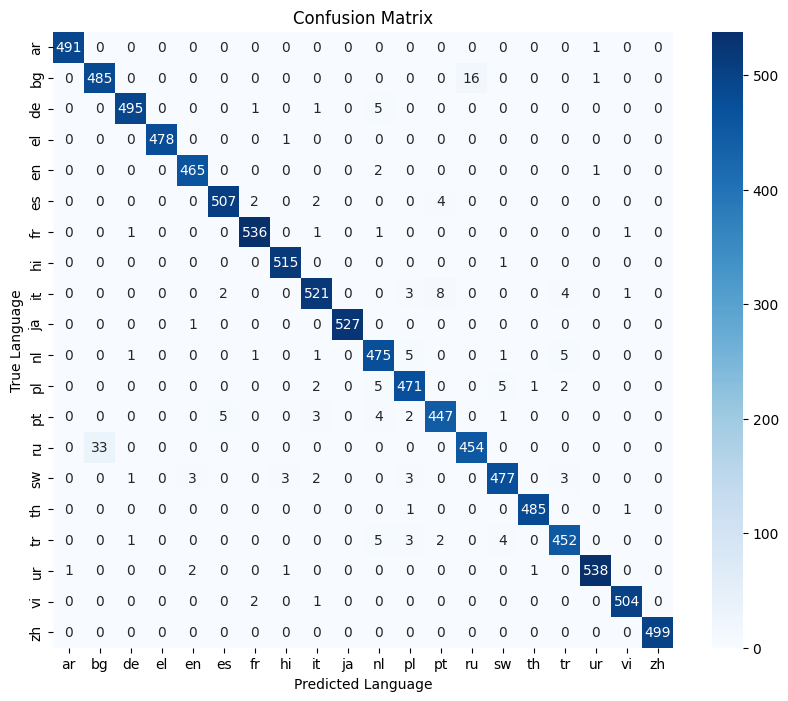

In [160]:
# i wykresik dla lepszego zobrazowania
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(lang_dict.values()), yticklabels=sorted(lang_dict.values()))
plt.xlabel('Predicted Language')
plt.ylabel('True Language')
plt.title('Confusion Matrix')
plt.show()